# Binary classification cats vs. dogs

* 50% of the cats vs. dogs data set with augmentation
* Transfer learning (Xception network) with fine-tuning
* Keras sequential API

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow import data

# Directory structure

Make sure you have the following directory structure under /kaggle/input/:

* .../train_validate (a directory with images for training and validation)
    * .../cats (a sub-directory with 12500 cats images)
    * .../dogs (a sub-directory with 12500 dogs images)
* .../test_dir/test (a directory with 12500 unlabelled images for testing)

**It is important the test_dir fodler contains a single "unlabelled" folder with all the test images in it. This is because ```image_dataset_from_directory``` expects at least a single directory under the specified path.**


To obtain the directory structure as above, you can use the output of my notebook "cats-vs-dogs-train-val-test-data"

# Set image and model parameters

Set a few parameters used in the model:

* image_size to resize the images after they are read from disk, all images must have the same size
* batch_size to set the batch size
* validation_share = 0.25 and training_share = 0.75 to use 25% of the original train-validate data for training and 75% for validation (any other numbers like 0.1 and 0.4 are possible).
* set base learning rate to 0.001 


In [4]:
image_size = (150,150)
batch_size = 16
validation_share = 0.1
training_share = 0.4
base_learning_rate = 0.001


<span style="color:blue"> 
**In tensorflow documentation, they take only 40% of images for training (it is also said that transfer learning performs better for smaller data sets) and 10% for validation and use data augmentation (horizontal flip).**
<span>
    
<span style="color:blue">     
**Why are we using the data augmentation then?  Why did not we use let's say 80% train-validate data (0.8* 25000 images) for training and 20% for validation (0.2* 25000 images) instead?** 
<span>

# Load images


In ```image_dataset_from_directory```, set

* ```validation_split = validation_share```  for validation dataset and ```validation_split = 1 - training_share``` for training dataset 
* the directory where the data are located
* ```labels = "inferred"``` to generate labels from the directory structure
* ```label_mode = 'binary'``` to encode the labels as scalars with values 0 and 1
* the explicit class names (which must match the names of the directories) to control the order of classes: ```class_names = ["cats", "dogs"]```
* ```color_mode = "rgb"```
* the batch size is ```batch_size``` for training and validation
* the batch size for testing is ```batch_size_testing```
* the size to resize the images after they read from disk, all images must have the same size
* ```shuffle = True``` for training and validation to shuffle the data and provide the ```seed``` argument to make sure there is no overlap between the training and validation datasets
* ```shuffle = False``` for testing data because we want to keep the datasets and their labels (filenames) ordered
* ```subset = "training"``` for training dataset and ```subset = "validation"``` for validation dataset
* ```label_mode = "binary"```  for training and validation
* ```label_mode = None``` for testing

In [5]:
train_validate_directory = '/kaggle/input/cats-vs-dogs-train-val-test-data/train_validate/'

training_ds = keras.preprocessing.image_dataset_from_directory(
    train_validate_directory, 
    labels='inferred', 
    label_mode='binary', 
    class_names = ["cats","dogs"], 
    color_mode='rgb',
    batch_size=batch_size, 
    image_size=image_size, 
    shuffle=True,
    seed=1,
    validation_split = 1 - training_share,
    subset="training",
)

Found 25000 files belonging to 2 classes.
Using 10000 files for training.


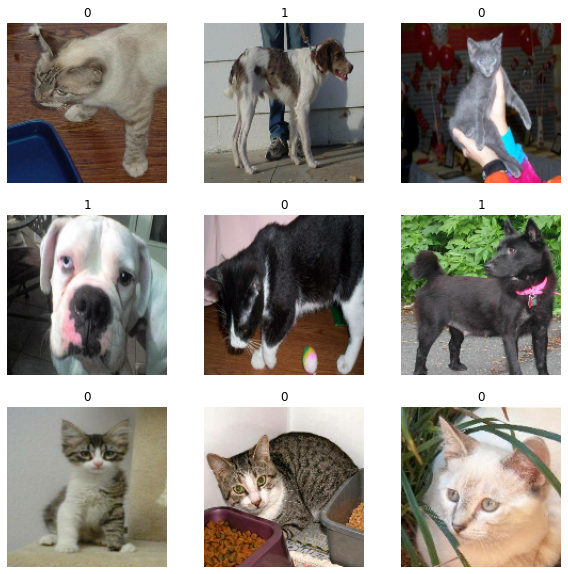

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
train_validate_directory = '/kaggle/input/cats-vs-dogs-train-val-test-data/train_validate/'

validation_ds = keras.preprocessing.image_dataset_from_directory(
    train_validate_directory, 
    labels='inferred', 
    label_mode='binary', 
    class_names = ["cats","dogs"], 
    color_mode='rgb', 
    batch_size=batch_size, 
    image_size=image_size,
    shuffle=True,
    seed = 1,
    validation_split = validation_share,
    subset="validation"
)

Found 25000 files belonging to 2 classes.
Using 2500 files for validation.


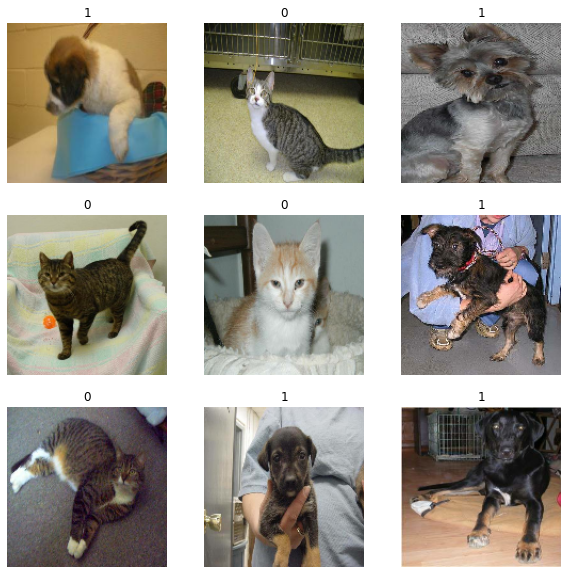

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in validation_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**To return test images *along with their corresponding paths*, I use an overriden IMAGE_DATASET_FROM_DIRECTORY function from here** https://github.com/tensorflow/tensorflow/blob/v2.3.0/tensorflow/python/keras/preprocessing/image_dataset.py#L34-L206

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.keras.layers.preprocessing import image_preprocessing
from tensorflow.python.keras.preprocessing import dataset_utils
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
from tensorflow.python.util.tf_export import keras_export

WHITELIST_FORMATS = ('.bmp', '.gif', '.jpeg', '.jpg', '.png')

## Tensorflow override method to return fname as list as well as dataset

def my_image_dataset_from_directory(directory,
                                 labels='inferred',
                                 label_mode='int',
                                 class_names=None,
                                 color_mode='rgb',
                                 batch_size=32,
                                 image_size=(256, 256),
                                 shuffle=True,
                                 seed=None,
                                 validation_split=None,
                                 subset=None,
                                 interpolation='bilinear',
                                 follow_links=False):
  
  if labels != 'inferred':
    if not isinstance(labels, (list, tuple)):
      raise ValueError(
          '`labels` argument should be a list/tuple of integer labels, of '
          'the same size as the number of image files in the target '
          'directory. If you wish to infer the labels from the subdirectory '
          'names in the target directory, pass `labels="inferred"`. '
          'If you wish to get a dataset that only contains images '
          '(no labels), pass `label_mode=None`.')
    if class_names:
      raise ValueError('You can only pass `class_names` if the labels are '
                       'inferred from the subdirectory names in the target '
                       'directory (`labels="inferred"`).')
  if label_mode not in {'int', 'categorical', 'binary', None}:
    raise ValueError(
        '`label_mode` argument must be one of "int", "categorical", "binary", '
        'or None. Received: %s' % (label_mode,))
  if color_mode == 'rgb':
    num_channels = 3
  elif color_mode == 'rgba':
    num_channels = 4
  elif color_mode == 'grayscale':
    num_channels = 1
  else:
    raise ValueError(
        '`color_mode` must be one of {"rbg", "rgba", "grayscale"}. '
        'Received: %s' % (color_mode,))
  interpolation = image_preprocessing.get_interpolation(interpolation)
  dataset_utils.check_validation_split_arg(
      validation_split, subset, shuffle, seed)

  if seed is None:
    seed = np.random.randint(1e6)
  image_paths, labels, class_names = dataset_utils.index_directory(
      directory,
      labels,
      formats=WHITELIST_FORMATS,
      class_names=class_names,
      shuffle=shuffle,
      seed=seed,
      follow_links=follow_links)

  if label_mode == 'binary' and len(class_names) != 2:
    raise ValueError(
        'When passing `label_mode="binary", there must exactly 2 classes. '
        'Found the following classes: %s' % (class_names,))

  image_paths, labels = dataset_utils.get_training_or_validation_split(
      image_paths, labels, validation_split, subset)

  dataset = paths_and_labels_to_dataset(
      image_paths=image_paths,
      image_size=image_size,
      num_channels=num_channels,
      labels=labels,
      label_mode=label_mode,
      num_classes=len(class_names),
      interpolation=interpolation)
  if shuffle:
    # Shuffle locally at each iteration
    dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
  dataset = dataset.batch(batch_size)
  # Users may need to reference `class_names`.
  dataset.class_names = class_names
  return dataset, image_paths

def paths_and_labels_to_dataset(image_paths,
                                image_size,
                                num_channels,
                                labels,
                                label_mode,
                                num_classes,
                                interpolation):
  """Constructs a dataset of images and labels."""
  # TODO(fchollet): consider making num_parallel_calls settable
  path_ds = dataset_ops.Dataset.from_tensor_slices(image_paths)
  img_ds = path_ds.map(
      lambda x: path_to_image(x, image_size, num_channels, interpolation))
  if label_mode:
    label_ds = dataset_utils.labels_to_dataset(labels, label_mode, num_classes)
    img_ds = dataset_ops.Dataset.zip((img_ds, label_ds))
  return img_ds


def path_to_image(path, image_size, num_channels, interpolation):
  img = io_ops.read_file(path)
  img = image_ops.decode_image(
      img, channels=num_channels, expand_animations=False)
  img = image_ops.resize_images_v2(img, image_size, method=interpolation)
  img.set_shape((image_size[0], image_size[1], num_channels))
  return img

Use 100% of the original test data (12500 images) for testing.

* set ```label_mode=None``` and ```batch_size=1```

In [8]:
testing_directory = '/kaggle/input/cats-vs-dogs-train-val-test-data/test_dir/'

#testing_ds = keras.preprocessing.image_dataset_from_directory(
testing_ds, testing_paths = my_image_dataset_from_directory(
    testing_directory, 
    label_mode=None, 
    color_mode='rgb', 
    batch_size=12500,
    image_size=image_size, 
    shuffle=False,
    seed = 1,
)

Found 12500 files belonging to 1 classes.


Print the number of batches

In [9]:
print("Number of training batches: %d" % data.experimental.cardinality(training_ds))
print("Number of validation batches: %d" % data.experimental.cardinality(validation_ds))
print("Number of test batches: %d" % data.experimental.cardinality(testing_ds))

Number of training batches: 625
Number of validation batches: 157
Number of test batches: 1


# Standardize the data

We need to normalize and rescale (intensity levels of) images. We will do this as part of the model.

## Resize the images

* One could resize the images as following:

```
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))
```

* Here we do this with ```tf.keras.layers.experimental.preprocessing.Resizing``` as part of the model

## Normalize pixel values

* To rescale an input in the [0, 255] range to be in the [-1, 1] range, we use 
```tf.keras.layers.experimental.preprocessing.Rescaling(scale = 1./127.5, offset = -1)``` as part of the model.


<span style="color:blue"> **From tensorflow documentation. Note: If using other tf.keras.applications, be sure to check the API doc to determine if they expect pixels in [-1,1] or [0,1], or use the included preprocess_input function.**</span>.


In [10]:
data_standardization = keras.Sequential([
        keras.layers.experimental.preprocessing.Resizing(image_size[0], image_size[1], interpolation='bilinear'),
        keras.layers.experimental.preprocessing.Rescaling(scale = 1./127.5, offset = -1)
])
    

## **Cache and prefetch the data to optimize loading speed**

From the tensorflow documentation:

* Caching saves some operations (like file opening and data reading) from being executed during each epoch.

* Prefetching overlaps the preprocessing and model execution of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1. Doing so reduces the step time to the maximum (as opposed to the sum) of the training and the time it takes to extract the data.

* Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed. This often improves latency and throughput, at the cost of using additional memory to store prefetched elements.

* The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to tf.data.experimental.AUTOTUNE which will prompt the tf.data runtime to tune the value dynamically at runtime.

* Note: Like other Dataset methods, prefetch operates on the elements of the input dataset. It has no concept of examples vs. batches. examples.prefetch(2) will prefetch two elements (2 examples), while examples.batch(20).prefetch(2) will prefetch 2 elements (2 batches, of 20 examples each).

In [11]:
training_ds = training_ds.cache().prefetch(data.experimental.AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(data.experimental.AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(data.experimental.AUTOTUNE)

# Data augmentation

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
        layers.experimental.preprocessing.RandomRotation(0.125),
        layers.experimental.preprocessing.RandomWidth(0.1),
        layers.experimental.preprocessing.RandomHeight(0.1),
        layers.experimental.preprocessing.RandomZoom(-0.1),
        layers.experimental.preprocessing.RandomTranslation(width_factor=0.1, height_factor=0.1),
        layers.experimental.preprocessing.RandomFlip("horizontal")
])

**Somehow, adding all trasformations worsens the performance.**

# Build a model

* Use Xception model as a base model
* Set weights to ```imagenet```
* Do not include the fully-connected layer at the top of the network
* Freeze the model

*From tensorflow documentation:*

*The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.*

In [13]:
base_model = keras.applications.Xception(
    weights="imagenet",
    input_shape=(image_size[0], image_size[1], 3),
    include_top=False,
)

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Create new model on top

* Make data augmentation and standardization (resizing and normalization) part of the model to benefit from the GPU acceleration (in case the model is trained on a GPU).

**Benefits of having data preprocessing as part of the model:**

When all data preprocessing is part of the model, other people can load and use your model without having to be aware of how each feature is expected to be encoded and normalized. 

* **Make sure to pass ```training=False``` when calling the base model!**

```x = base_model(x, training = False)```

This ensures the model runs in inference mode, so that batchnorm statistics is not updated even after we unfreeze the base model for fine tuning.  


* Add a ```Dropout``` layer before the classification layer for regularization.


In [14]:
inputs = keras.Input(shape=(image_size[0],image_size[0],3))

x = data_augmentation(inputs)
x = data_standardization(x)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) 

outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs,outputs)

model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

# Train the top layer

* Use ```keras.losses.BinaryCrossentropy()``` loss because there are only two classes and set ```from_logits=True``` as the model itself does not implement a sigmoid activation of the last layer.
* Use SGD with momentum as optimization algorithm.

In [15]:
model.compile(
    optimizer = keras.optimizers.SGD(lr=base_learning_rate, momentum=0.9, nesterov=True),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [keras.metrics.BinaryAccuracy()],
)

In [16]:
initial_epochs = 20

history = model.fit(training_ds, 
                    epochs = initial_epochs, 
                    validation_data=validation_ds,
                    verbose = 1)

Epoch 1/20
625/625 [==============================] - 73s 116ms/step - loss: 0.2372 - binary_accuracy: 0.8885 - val_loss: 0.0856 - val_binary_accuracy: 0.9676
Epoch 2/20
625/625 [==============================] - 21s 34ms/step - loss: 0.1846 - binary_accuracy: 0.9145 - val_loss: 0.0778 - val_binary_accuracy: 0.9684
Epoch 3/20
625/625 [==============================] - 21s 34ms/step - loss: 0.1841 - binary_accuracy: 0.9192 - val_loss: 0.0759 - val_binary_accuracy: 0.9712
Epoch 4/20
625/625 [==============================] - 21s 33ms/step - loss: 0.1802 - binary_accuracy: 0.9183 - val_loss: 0.0762 - val_binary_accuracy: 0.9720
Epoch 5/20
625/625 [==============================] - 21s 33ms/step - loss: 0.1683 - binary_accuracy: 0.9269 - val_loss: 0.0756 - val_binary_accuracy: 0.9704
Epoch 6/20
625/625 [==============================] - 21s 33ms/step - loss: 0.1719 - binary_accuracy: 0.9267 - val_loss: 0.0707 - val_binary_accuracy: 0.9744
Epoch 7/20
625/625 [==============================]

In [17]:
model.save('cats-vs-dogs-xception-50pct-augm.h5')

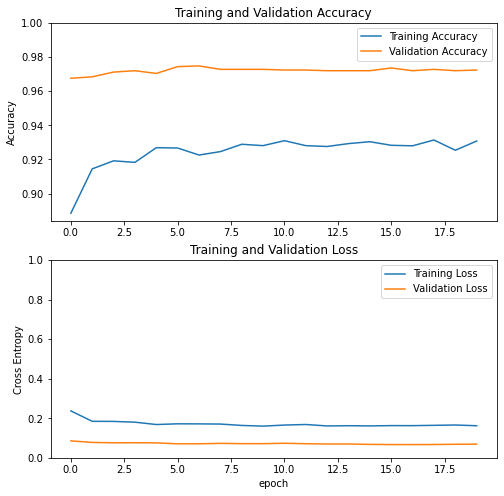

In [18]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Sometimes, the validation accuracy is higher than the training accuracy. In this case,

From TF documentation:

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

# Fine-tuning

In [19]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 3)     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                

* All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [20]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  132


* Recompile the model
* From TF documentation: As you are training a much larger model (on a data set that is rather small) and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.

In [21]:
model.compile(
    optimizer=keras.optimizers.SGD(lr = base_learning_rate / 10, momentum = 0.9, nesterov=True),
    loss=keras.losses.BinaryCrossentropy(from_logits = True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [22]:
fine_tune_epochs = 10

total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(training_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds)

Epoch 20/30
625/625 [==============================] - 30s 48ms/step - loss: 0.1543 - binary_accuracy: 0.9316 - val_loss: 0.0642 - val_binary_accuracy: 0.9744
Epoch 21/30
625/625 [==============================] - 29s 46ms/step - loss: 0.1489 - binary_accuracy: 0.9385 - val_loss: 0.0634 - val_binary_accuracy: 0.9740
Epoch 22/30
625/625 [==============================] - 29s 46ms/step - loss: 0.1381 - binary_accuracy: 0.9405 - val_loss: 0.0605 - val_binary_accuracy: 0.9772
Epoch 23/30
625/625 [==============================] - 30s 47ms/step - loss: 0.1364 - binary_accuracy: 0.9417 - val_loss: 0.0589 - val_binary_accuracy: 0.9784
Epoch 24/30
625/625 [==============================] - 29s 47ms/step - loss: 0.1333 - binary_accuracy: 0.9439 - val_loss: 0.0584 - val_binary_accuracy: 0.9780
Epoch 25/30
625/625 [==============================] - 29s 47ms/step - loss: 0.1315 - binary_accuracy: 0.9413 - val_loss: 0.0578 - val_binary_accuracy: 0.9792
Epoch 26/30
625/625 [=========================

In [23]:
acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

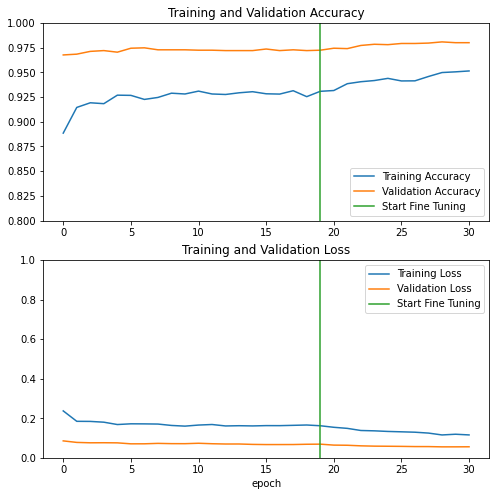

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We reach 97.5% accuracy without fine-tuning. From iteration 21-22 on-wards, training accuracy increases and validation accuracy stays the same. The model begins to overfit. 



# Make predictions

In [ ]:
predictions = model.predict(testing_ds, verbose=1, steps = 1)

In [ ]:
predicted_label = []
predicted_label = [int(round(probability[0])) for probability in predictions]

In [ ]:
import numpy as np
id = []
for testing_path in testing_paths:
    id.append(testing_path.split('.')[0].split('/')[-1])

In [ ]:
import pandas as pd
submission_df = pd.DataFrame({'id':id, 'label':predicted_label})
submission_df = submission_df.sort_values(by=['id'])

In [1]:
len(predictions)

NameError: name 'predictions' is not defined

In [ ]:
submission_df.to_csv("submission.csv", index=False)

In [ ]:
model.save('cats-vs-dogs-xception-full-dataset.h5')

In [ ]:
from IPython.display import FileLink
FileLink(r'cats-vs-dogs-xception-full-dataset.h5')